In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from heapq import heappop, heappush
from random import randint
%matplotlib inline

In [2]:
# rectangle (n x m), n >= m >= 0
def simple_intersect_cells(n, m):
    cells = []
    cells.append((0, 0))
    for i in range(1, n):
        y = i * m // n
        x = i
        cells.append((x, y))
        cells.append((x - 1, y))
        if y * n == i * m and y >= 0:
            cells.append((x, y - 1))
            cells.append((x - 1, y - 1))
    return cells
    

In [3]:
def intersect_cells(i1, j1, i2, j2):
    cells = []
    start = (i1, j1)
    
    s1 = 1
    if i1 > i2:
        s1 = -1
        i1, i2 = i2, i1
    
    s2 = 1
    if j1 > j2:
        s2 = -1
        j1, j2 = j2, j1
    
    r = 0
    if j2 - j1 > i2 - i1:
        r = 1
        i1, i2, j1, j2 = j1, j2, i1, i2
        s1, s2 = s2, s1
    
    n = i2 - i1
    m = j2 - j1
    s_cells = simple_intersect_cells(n, m)
    for cell in s_cells:
        if r == 1:
            cells.append((start[0] + cell[1] * s2, start[1] + cell[0] * s1))
        else:
            cells.append((start[0] + cell[0] * s1, start[1] + cell[1] * s2))
    return cells
    
    

In [41]:
def draw_intersect(width, height):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 50
    r = 0.05 * k
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    
    cells = simple_intersect_cells(width, height)
    
    for cell in cells:
        j = cell[0]
        i = cell[1]
        draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(231, 76, 60))
        
    # grid points
    for i in range(height + 1):
        for j in range(width + 1):
            draw.ellipse((j * k - r, i * k - r, j * k + r, i * k + r), fill=(50, 50, 50))
            
    draw.line((0, 0, width * k, height * k),  fill=( 70, 80, 80 ))
        

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

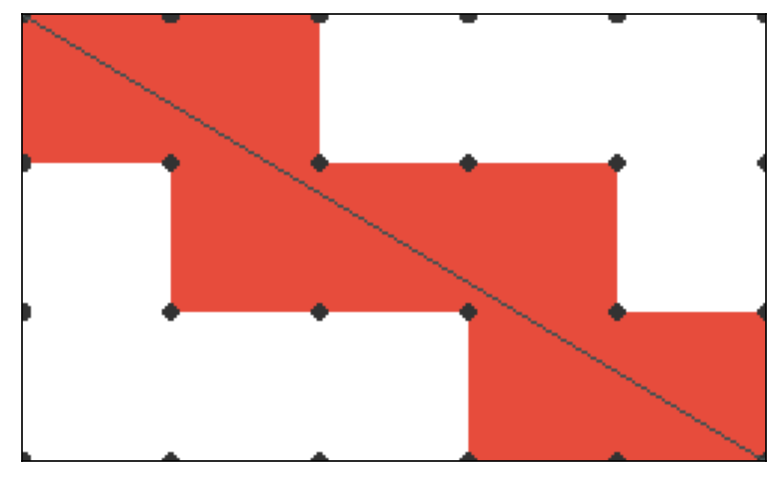

In [42]:
draw_intersect(5, 3)

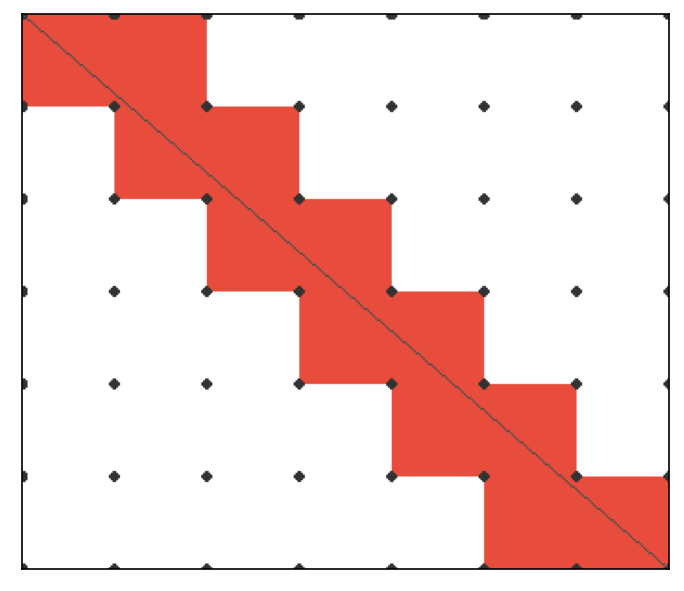

In [43]:
draw_intersect(7, 6)

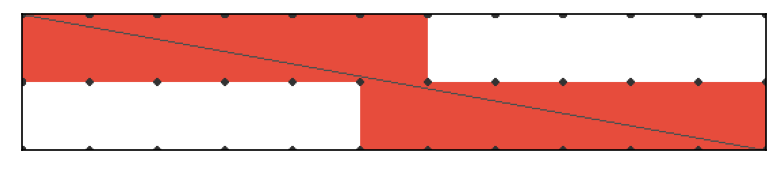

In [44]:
draw_intersect(11, 2)

In [4]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '@' and 'T' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '@' or c == 'T':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells

    def cell_in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)

    def point_in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j <= self._width) and (0 <= i <= self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return self.cell_in_bounds(i, j) and (not self._cells[i][j])
    
    def cells_by_delta(self, di, dj):
        if di == 1 and dj == 0:
            return [[0, 0], [0, -1]]
        if di == -1 and dj == 0:
            return [[-1, 0], [-1, -1]]
        if di == 0 and dj == 1:
            return [[0, 0], [-1, 0]]
        if di == 0 and dj == -1:
            return [[0, -1], [-1, -1]]


    def get_neighbors_with_grid_point(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected and we can't cut angles
        '''   
        neighbors = []
        delta_straight = [[0, 1], [1, 0], [0, -1], [-1, 0]]
#        delta_straight = []
        delta_diag = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
#        delta_diag = []

        for d in delta_straight:
            if self.point_in_bounds(i + d[0], j + d[1]):
                cells = self.cells_by_delta(d[0], d[1])
                if self.traversable(i + cells[0][0], j + cells[0][1]) or self.traversable(i + cells[1][0], j + cells[1][1]):
                    neighbors.append((i + d[0], j + d[1]))
                
                
        for d in delta_diag:
            if self.point_in_bounds(i + d[0], j + d[1]) and self.traversable(i + (d[0] - 1) // 2, j + (d[1] - 1) // 2):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors
    
    def visible(self, i1, j1, i2, j2):
        cells = intersect_cells(i1, j1, i2, j2)
        for cell in cells:
            if not self.traversable(cell[0], cell[1]):
                return False
        return True

    def get_size(self):
        return (self._height, self._width)


In [5]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    return sqrt(abs(i1 - i2) ** 2 + abs(j1 - j2) ** 2)


In [6]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node

    '''

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, tie_breaking_func = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j) # TODO I also want to compare parents 
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)
    
    # this function defines order of taking nodes from OPEN
    def priority(self):
        return self.f, -self.g

    def __lt__(self, other):
        return (self.i, self.j) < (other.i, other.j)
    
    def __le__(self, other):
        return (self.i, self.j) <= (other.i, other.j)
    
    def __gt__(self, other):
        return (self.i, self.j) > (other.i, other.j)
    
    def __ge__(self, other):
        return (self.i, self.j) >= (other.i, other.j)
    
    def __eq__(self, other):
        return (self.i, self.j) == (other.i, other.j)
    
    def __ne__(self, other):
        return (self.i, self.j) != (other.i, other.j)
    

In [7]:
class SearchTreePQS: #SearchTree which uses PriorityQueue for OPEN and set for CLOSED
    
    def __init__(self):
        self._open = [] # priority queue (node.priority, node)
        self._closed = set()
        
    def __len__(self):
        return len(self._open) + len(self._closed)
    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a node to the search-tree (i.e. to OPEN).
    It's may be a duplicate, and it will be checked in 
    'get_best_node_from_open' method
    '''    
    def add_to_open(self, item):
        heappush(self._open, (item.priority(), item))
        return    
    
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    Can't return a duplicate.
    return Null if open consist of ONLY closed nodes.
    ''' 
    def get_best_node_from_open(self):
        while not self.open_is_empty():
            bestf, best = heappop(self._open)
            if not (self.was_expanded(best)):
                return best
        return None

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return [item[1] for item in self._open]
    
    @property
    def CLOSED(self):
        return self._closed


In [8]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent != current:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [9]:
def getSuccessor(node, i, j, grid_map, goal_i, goal_j, heuristic_func):
    if grid_map.visible(node.parent.i, node.parent.j, i, j):
        return Node(i, j, g = node.parent.g + compute_cost(node.parent.i, node.parent.j, i, j),
                        h = heuristic_func(i, j, goal_i, goal_j), parent = node.parent)
    else:
        return Node(i, j, g = node.g + compute_cost(node.i, node.j, i, j),
                        h = heuristic_func(i, j, goal_i, goal_j), parent = node)

In [10]:
def getSuccessors(node, grid_map, goal_i, goal_j, heuristic_func):
    neighbors = grid_map.get_neighbors_with_grid_point(node.i, node.j)
    successors = []
    for cell in neighbors:
        successors.append(getSuccessor(node, cell[0], cell[1], grid_map, goal_i, goal_j, heuristic_func))
    return successors

### Visualization

In [11]:
def draw(grid_map, start = None, goal = None, path = None,
         nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 15
    r = 0.3 * k
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    # grid points
    for i in range(height + 1):
        for j in range(width + 1):
            pass
#            draw.ellipse((j * k - r, i * k - r, j * k + r, i * k + r), fill=(50, 50, 50))
    
    # obstacles
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    # opened
    if nodes_opened is not None:
        for node in nodes_opened:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
    
    # expanded
    if nodes_expanded is not None:
        for node in nodes_expanded:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)
    
    # reexpanded
    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
            pass
#                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)
    
    # path
    if path is not None:
        for step in path:
            if (step is not None):
                draw.line(((step.j * k, step.i * k), (step.parent.j * k, step.parent.i * k)), fill=(52, 152, 219))
                draw.ellipse((step.j * k - r, step.i * k - r, step.j * k + r, step.i * k + r), fill=(52, 152, 219))
                

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.ellipse((start.j * k - r, start.i * k - r, start.j * k + r, start.i * k + r), fill=(40, 180, 99))
    
    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.ellipse((goal.j * k - r, goal.i * k - r, goal.j * k + r, goal.i * k + r), fill=(231, 76, 60))


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


Example of the visualization

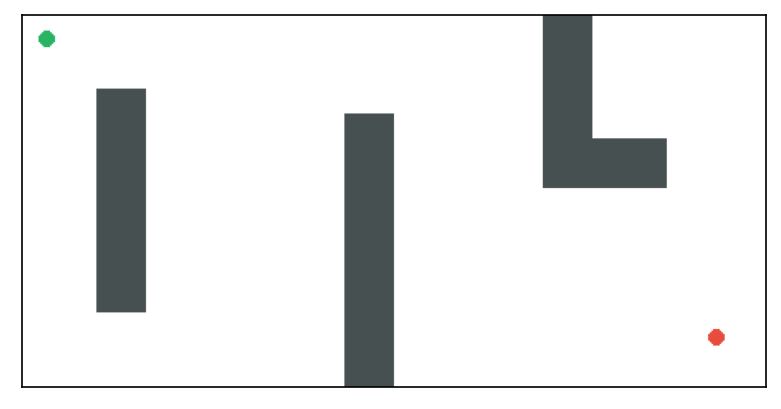

In [12]:

height = 15
width = 30
map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

In [13]:
def simple_test(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4), (7, 1)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29), (4, 26)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44, 0]

    if (task is None) or not (0 <= task < 26):
        task = randint(0, 25)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = make_path(result[1])
            correct = int(path[1])  == int(length)
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps) + ". Correct: " + str(correct))
            draw(task_map, start, goal, path[0], *result[4:])
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


In [14]:
def euclidian_distance(i1, j1, i2, j2):
    
    return sqrt((i1 - i2)**2 + (j1 - j2)**2)


In [15]:
def theta(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):

    ast = search_tree() 
    start = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j), parent=None)
    start.parent = start
    ast.add_to_open(start)
    steps = 0
    nodes_created = 0
    
    print("start: ", start.i, start.j)
        
    print("goal: ", goal_i, goal_j)
    
    while not ast.open_is_empty():
        curr = ast.get_best_node_from_open()
        if curr is None:
            break
            
        ast.add_to_closed(curr)
        
        if (curr.i == goal_i) and (curr.j == goal_j): # curr is goal
            return  (True, curr, steps, nodes_created, ast.OPEN, ast.CLOSED)
        
        # expanding curr
        successors = getSuccessors(curr, grid_map, goal_i, goal_j, heuristic_func)
        
        for node in successors:
            if not ast.was_expanded(node):
                ast.add_to_open(node)
        
    
    return (False, None, steps, nodes_created, ast.OPEN, ast.CLOSED)

start:  7 1
goal:  4 26
Path found! Length: 30.644429070992935. Nodes created: 0. Number of steps: 0. Correct: False


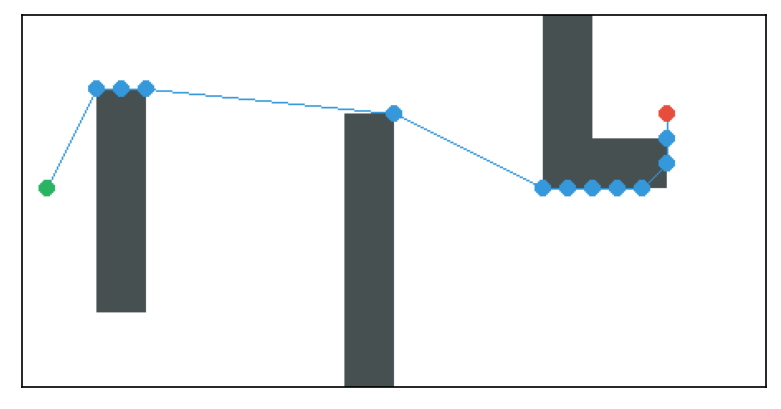

CPU times: user 132 ms, sys: 96.1 ms, total: 228 ms
Wall time: 132 ms


In [16]:
%time res = simple_test(theta, 25, euclidian_distance, SearchTreePQS)